# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [2]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '4e1d3e557',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': 'C:\\Users\\aluce\\anaconda3\\Lib\\site-packages\\IPython',
 'ipython_version': '8.12.3',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.22621-SP0',
 'sys_executable': 'c:\\Users\\aluce\\anaconda3\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit '
                '(AMD64)]'}


In [3]:
# %pip install -r "C:\Users\jesus\Desktop\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt" 

# %pip install -r '/home/xnmaster/Project/XNAPproject-grup07/our_code/frozen-requirements.txt'

In [4]:
# %pip install tensorflow[and-cuda]

In [5]:
# %pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

In [6]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

In [7]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1997343659346162205
xla_global_id: -1
]


In [8]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [9]:
# %pip install Pillow --upgrade

In [10]:
# globals

# DATA_DIR =  '/home/xnmaster/Project/input' 
# TRAIN_1_DIR = '/home/xnmaster/Project/input/train_30_artists'  

DATA_DIR = "../.." 
TRAIN_1_DIR = "../../train_10_selected_artists"


# DATA_DIR = r"/Users/jesus/Desktop/Projecte/" 
# TRAIN_1_DIR =  r"/Users/jesus/Desktop/Projecte/train_1" 

# TRAIN_2_DIR = '../input/painters-train-part-1/train_2/train_2/'
# TRAIN_3_DIR = '../input/painters-train-part-1/train_3/train_3/'

# TRAIN_4_DIR = '../input/painters-train-part-2/train_4/train_4/'
# TRAIN_5_DIR = '../input/painters-train-part-2/train_5/train_5/'
# TRAIN_6_DIR = '../input/painters-train-part-2/train_6/train_6/'

# TRAIN_7_DIR = '../input/painters-train-part-3/train_7/train_7/'
# TRAIN_8_DIR = '../input/painters-train-part-3/train_8/train_8/'
# TRAIN_9_DIR = '../input/painters-train-part-3/train_9/train_9/'

# TRAIN_DIRS = [TRAIN_1_DIR, TRAIN_2_DIR, TRAIN_3_DIR,
#              TRAIN_4_DIR, TRAIN_5_DIR, TRAIN_6_DIR,
#              TRAIN_7_DIR, TRAIN_8_DIR, TRAIN_9_DIR]

TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
# TEST_DIR = '/home/xnmaster/Project/input/test' 
TEST_DIR = "../../test"

Execute in local and virtual
(no cal cada vegada, només una vegada pq elimina les fotos que no són vàlides)

In [11]:
from PIL import Image
import os

# Function to check if a file is an image
def is_image(file_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in image_extensions)

# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Invalid image: {file_path} - {e}")
        # Remove the file if it's invalid
        os.remove(file_path)
        print(f"Removed file: {file_path}")
        return False

# Validate images in a directory
def validate_images(directory):
    print(f"Validating images in directory: {directory}")
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and is_image(file_path):
            if is_valid_image(file_path):
                print(f"Valid image: {file_path}")

# Validate training and testing directories
def validate_directories(*directories):
    for directory in directories:
        if not os.path.exists(directory):
            raise ValueError(f"Directory does not exist: {directory}")
        if not os.path.isdir(directory):
            raise ValueError(f"Not a directory: {directory}")

# Validate training and testing directories
validate_directories(DATA_DIR, TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_directories(train_dir)

# Validate images in training and testing directories
validate_images(DATA_DIR)
validate_images(TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_images(train_dir)


Validating images in directory: ../..
Valid image: ../..\final_loss_and_acc.png
Valid image: ../..\Imatge de WhatsApp 2024-05-31 a les 09.31.57_e698853b.jpg
Valid image: ../..\train_val_acc_over_epoch.jpg
Valid image: ../..\val_acc_over_epoch.png
Valid image: ../..\val_loss_over_epoch.png
Validating images in directory: ../../test
Valid image: ../../test\112.jpg
Valid image: ../../test\116.jpg
Valid image: ../../test\127.jpg
Valid image: ../../test\131.jpg
Valid image: ../../test\132.jpg
Valid image: ../../test\149.jpg
Valid image: ../../test\154.jpg
Valid image: ../../test\161.jpg
Valid image: ../../test\167.jpg
Valid image: ../../test\188.jpg
Valid image: ../../test\190.jpg
Valid image: ../../test\193.jpg
Valid image: ../../test\200.jpg
Valid image: ../../test\202.jpg
Valid image: ../../test\206.jpg
Valid image: ../../test\214.jpg
Valid image: ../../test\219.jpg
Valid image: ../../test\224.jpg
Valid image: ../../test\251.jpg
Valid image: ../../test\258.jpg
Valid image: ../../test\263

In [12]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 3886
Number of files in the folder TEST_DIR: 61


After augmentation

In [13]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 3886
Number of files in the folder TEST_DIR: 61


In [15]:
# df = pd.read_csv(DATA_DIR + 'all_data_info.csv/all_data_info.csv') 
df = pd.read_csv(DATA_DIR + '/all_data_info.csv') # r'\all_data_info\all_data_info.csv'
print("df.shape", df.shape)

df.shape (103250, 12)


In [16]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


Keep the works of artists who have a representation above 50%

In [32]:
training_set_artists = ["Camille Pissarro", "Vincent van Gogh", "Teophile Steinlen", "Pierre-Auguste Renoir", "Boris Kustodiev", "Pyotr Konchalovsky", "Gustave Dore", "Edgar Degas", "Camille Corot", "Eugene Boudin"]

In [33]:
filtered_df = df[df['artist'].isin(training_set_artists)]
filtered_df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
28,Gustave Dore,1866,religious painting,4915.0,6068.0,29811319.0,wikiart,Romanticism,Death of Eleazer,train_and_test,True,7486.jpg
29,Gustave Dore,NaN,religious painting,4770.0,6219.0,32443139.0,wikiart,Romanticism,The-Deluge,train_and_test,True,35766.jpg
34,Gustave Dore,NaN,illustration,5878.0,4678.0,24158097.0,wikiart,Romanticism,The hoarders and wasters,train_and_test,False,31977.jpg
147,Edgar Degas,1869,interior,5382.0,3349.0,1824204.0,wikiart,Impressionism,Interior (The Rape),train_and_test,True,95360.jpg
279,Pierre-Auguste Renoir,1917,sketch and study,4476.0,3396.0,8423735.0,wikiart,Impressionism,Sitting Girl,train_and_test,False,85018.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
101175,Pyotr Konchalovsky,1940,flower painting,374.0,450.0,52028.0,wikiart,Realism,Still Life. Lilacs in the window.,train_and_test,False,60223.jpg
101176,Pyotr Konchalovsky,1908,portrait,374.0,450.0,50917.0,wikiart,Post-Impressionism,Paris. The boy with the apple. (Portrait of Mi...,train_and_test,True,101511.jpg
101178,Pyotr Konchalovsky,1954,landscape,450.0,374.0,74238.0,wikiart,Realism,Under the trees,train_and_test,True,37915.jpg
101180,Pyotr Konchalovsky,1923,portrait,450.0,374.0,43756.0,wikiart,Realism,The night watchman with a dog (Ivan Payala),train_and_test,True,48670.jpg


In [31]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

test_df.shape (972, 2)
train_df.shape (4469, 2)


In [34]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
147,Edgar Degas,95360.jpg
279,Pierre-Auguste Renoir,85018.jpg


In [35]:
t1_df = t_df[t_df['new_filename'].str.startswith('1')]

t2_df = t_df[t_df['new_filename'].str.startswith('2')]

t3_df = t_df[t_df['new_filename'].str.startswith('3')]

t4_df = t_df[t_df['new_filename'].str.startswith('4')]

t5_df = t_df[t_df['new_filename'].str.startswith('5')]

t6_df = t_df[t_df['new_filename'].str.startswith('6')]

t7_df = t_df[t_df['new_filename'].str.startswith('7')]

t8_df = t_df[t_df['new_filename'].str.startswith('8')]

t9_df = t_df[t_df['new_filename'].str.startswith('9')]

all_train_dfs = [t1_df, t2_df, t3_df,
                t4_df, t5_df, t6_df,
                t7_df, t8_df, t9_df]

t9_df.head(5)

,artist,new_filename
147,Edgar Degas,95360.jpg
768,Camille Corot,90288.jpg
791,Edgar Degas,92192.jpg
1268,Edgar Degas,99133.jpg
1424,Edgar Degas,98645.jpg


In [36]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# specify the model that classifies 38 artists 🎨 🖌

## wandb
Execute following lines if we use wandb

In [37]:
# %pip install wandb -qU

In [38]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()
# 0927244f833ccea1b247099feaaaf54084a5c30c

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1608667 (xarxes_projecte). Use `wandb login --relogin` to force relogin


True

## without wandb

In [39]:
len(training_set_artists)

10

In [20]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

model_adam.layers[0].trainable = False

In [ ]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))

model_adam.add(Dense(
  num_classes,
  activation='relu'
))

model_adam.add(Dense(
  num_classes,
  activation='softmax'
))


model_adam.layers[0].trainable = False

In [23]:
model_sgd = Sequential()

model_sgd.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_sgd.add(Dense(
  num_classes,
  activation='softmax'
))

model_sgd.layers[0].trainable = False

In [24]:
model_RMS = Sequential()
model_RMS.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_RMS.add(Dense(
  num_classes,
  activation='softmax'
))

model_RMS.layers[0].trainable = False

# Compile Model

## Adam

In [21]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

**Observation**
para un problema de clasificación binaria, a menudo se utiliza la 'entropía cruzada binaria', mientras que la 'entropía cruzada categórica' se utiliza para la clasificación de clases múltiples.
https://www.sourcetrail.com/es/pit%C3%B3n/keras/modelo-compilar-keras/

## SGD

In [26]:
model_sgd.compile(
  optimizer='sgd', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

## RMSprop

In [27]:
model_RMS.compile(optimizer ='RMSprop', 
              loss ='categorical_crossentropy', 
              metrics =['accuracy'])

# Setup the image data generator for each training directory 

In [22]:
print("Files in train:", num_files_in_train)
print("Files in test:", num_files_in_test)

Files in train: 9319
Files in test: 7025


In [23]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 1
TEST_BATCH_SIZE: 25


In [24]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [25]:
def setup_generators(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-"*20)
    if not preprocess_input:
          raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # setup resnet50 preprocessing 
    data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )

    print(len(train_dataframe), "images in", train_dir, "and validation_split =", val_split)
    print("\ntraining set ImageDataGenerator")
    train_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        subset="training",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nvalidation set ImageDataGenerator")
    valid_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        subset="validation",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size,img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\ntest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False, # dont shuffle test directory
        class_mode=None,
        target_size=(img_size,img_size)
    )

    return (train_gen, valid_gen, test_gen)

print("defined setup_generators()")

defined setup_generators()


In [32]:
# delete some unused dataframes to free some RAM for training
del df
del t_df
del t1_df
del t2_df
del t3_df
del t4_df
del t5_df
del t6_df
del t7_df
del t8_df
del t9_df
gc.collect()

24686

In [26]:
train_gens = [None]
valid_gens = [None]
test_gen  = None # only 1 test_gen
i = 0
for i in range(0, 1):
    train_gens[i], valid_gens[i], test_gen = setup_generators(
        train_dataframe=t_df, train_dir=TRAIN_DIRS[0],
        val_split=VAL_SPLIT, img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, my_seed=MY_SEED, 
        list_of_classes=training_set_artists, test_dataframe=test_df, 
        test_dir=TEST_DIR, test_batch_size=TEST_BATCH_SIZE
    )

--------------------
14878 images in /home/xnmaster/Project/input/train_30_artists and validation_split = 0.25

training set ImageDataGenerator
Found 6990 validated image filenames belonging to 30 classes.

validation set ImageDataGenerator
Found 2329 validated image filenames belonging to 30 classes.


/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 5559 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 5559 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(



test set ImageDataGenerator
Found 7025 validated image filenames.


/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 16789 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [27]:
MAX_EPOCHS = 5 * 2 #len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [28]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## wandb

In [30]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_relu_9319im_30art"
)

# [optional] use wandb.config as your config
# config = run.config


In [31]:
for i in range(len(train_gens)):
    histories_adam = model_adam.fit(
        x=train_gens[0],
        epochs=10,
        batch_size=BATCH_SIZE,
        validation_data=valid_gens,
        callbacks=[
            WandbMetricsLogger(log_freq=10)
        ],
    )


Epoch 1/10
6990/6990 [==============================] - 369s 52ms/step - loss: 2.5794 - accuracy: 0.4692 - val_loss: 8.6869 - val_accuracy: 0.3422
Epoch 2/10
6990/6990 [==============================] - 363s 52ms/step - loss: 2.0447 - accuracy: 0.6040 - val_loss: 10.3141 - val_accuracy: 0.3246
Epoch 3/10
6990/6990 [==============================] - 361s 52ms/step - loss: 1.8588 - accuracy: 0.6559 - val_loss: 12.3770 - val_accuracy: 0.3036
Epoch 4/10
6990/6990 [==============================] - 361s 52ms/step - loss: 1.7103 - accuracy: 0.6906 - val_loss: 12.3709 - val_accuracy: 0.3117
Epoch 5/10
6990/6990 [==============================] - 362s 52ms/step - loss: 1.5665 - accuracy: 0.7107 - val_loss: 12.5306 - val_accuracy: 0.3139
Epoch 6/10
6990/6990 [==============================] - 361s 52ms/step - loss: 1.5455 - accuracy: 0.7260 - val_loss: 11.3078 - val_accuracy: 0.3766
Epoch 7/10
6990/6990 [==============================] - 360s 51ms/step - loss: 1.4481 - accuracy: 0.7352 - val_lo

In [32]:
run.finish()

batch/accuracy,▁▂▃▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇██▇▇████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▅▃▃▃▄▃▃▃▃▂▂▂▃▂▂▂▂▁▂▂▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▇▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▂▁▁
epoch/val_accuracy,▅▃▂▂▂█▁▄▆▂
epoch/val_loss,▁▃▆▆▆▄█▇▆▇
batch/accuracy,0.76436


In [ ]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "sgd_13000im_10art"
)

In [ ]:
histories_sgd = model_sgd.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.3816 - accuracy: 0.2386 - val_loss: 3.5298 - val_accuracy: 0.2519
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 1.3757 - accuracy: 0.5178 - val_loss: 3.7344 - val_accuracy: 0.3282
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 1.0062 - accuracy: 0.6675 - val_loss: 3.9953 - val_accuracy: 0.3206
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.8215 - accuracy: 0.7259 - val_loss: 4.0012 - val_accuracy: 0.3511
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.6924 - accuracy: 0.7944 - val_loss: 4.1198 - val_accuracy: 0.3206
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.5992 - accuracy: 0.8198 - val_loss: 4.1945 - val_accuracy: 0.3282
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.5324 - accuracy: 0.8655 - val_loss: 4.2109 - val_accuracy: 0.3740
Epoch 8/20
8/8 [==================

In [ ]:
run.finish()

batch/accuracy,▁▄▆▆▇▇▇▇▇█▇▇▇███████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▇▇▇▇▇▇█████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▄▆▄▅▇██▇▇▇▇▇█▇████
epoch/val_loss,▁▂▄▄▅▅▆▅▆▆▇▇▇▇▇▇████
batch/accuracy,0.98077


In [ ]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "rms_13000im_10art"
)

In [ ]:
histories_RMS = model_RMS.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.2772 - accuracy: 0.2792 - val_loss: 3.8644 - val_accuracy: 0.2672
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 1.1213 - accuracy: 0.6091 - val_loss: 3.9901 - val_accuracy: 0.3588
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.8072 - accuracy: 0.7310 - val_loss: 4.1888 - val_accuracy: 0.3740
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.6552 - accuracy: 0.7995 - val_loss: 4.3235 - val_accuracy: 0.3664
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.4821 - accuracy: 0.8832 - val_loss: 4.6318 - val_accuracy: 0.3588
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.3770 - accuracy: 0.9137 - val_loss: 4.6329 - val_accuracy: 0.3588
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.2880 - accuracy: 0.9467 - val_loss: 4.9450 - val_accuracy: 0.3893
Epoch 8/20
8/8 [==================

In [ ]:
run.finish()

batch/accuracy,▁▅▆▇█▇██████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▇▇▇▇████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▆▅▅▇▆█▇▅▇██▇▆▇▇█▆
epoch/val_loss,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▆▆▇███
batch/accuracy,1.0


## manual

In [ ]:
histories_adam2 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam2.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

In [ ]:
histories_sgd = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_sgd.append(
            model_sgd.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 20s 3s/step - loss: 2.3205 - accuracy: 0.2251 - val_loss: 3.2048 - val_accuracy: 0.2404
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 14s 2s/step - loss: 1.3750 - accuracy: 0.5322 - val_loss: 3.2416 - val_accuracy: 0.2788
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 1.0510 - accuracy: 0.6871 - val_loss: 3.3881 - val_accuracy: 0.3173
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8841 - accuracy: 0.7281 - val_loss: 3.4871 - val_accuracy: 0.3365
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7446 - accuracy: 0.7836 - val_loss: 3.5372 - val_accuracy: 0.3269


In [ ]:
histories_RMS = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_RMS.append(
            model_RMS.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 19s 3s/step - loss: 2.0293 - accuracy: 0.3129 - val_loss: 4.1664 - val_accuracy: 0.3654
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 1.0891 - accuracy: 0.6462 - val_loss: 4.6713 - val_accuracy: 0.3269
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8115 - accuracy: 0.7281 - val_loss: 4.3325 - val_accuracy: 0.4135
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.6265 - accuracy: 0.8187 - val_loss: 4.8583 - val_accuracy: 0.3654
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 16s 2s/step - loss: 0.4779 - accuracy: 0.8764 - val_loss: 5.2872 - val_accuracy: 0.3365


# Evaluate the model 🧐 🤔

In [ ]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

In [ ]:
accuracies_sgd = []
val_accuracies_sgd = []
losses_sgd = []
val_losses_sgd = []
for hist in histories_sgd:
    if hist:
        accuracies_sgd += hist.history['accuracy']
        val_accuracies_sgd += hist.history['val_accuracy']
        losses_sgd += hist.history['loss']
        val_losses_sgd += hist.history['val_loss']

In [ ]:
accuracies_RMS = []
val_accuracies_RMS = []
losses_RMS = []
val_losses_RMS = []
for hist in histories_RMS:
    if hist:
        accuracies_RMS += hist.history['accuracy']
        val_accuracies_RMS += hist.history['val_accuracy']
        losses_RMS += hist.history['loss']
        val_losses_RMS += hist.history['val_loss']

## Plots
### Accuracies

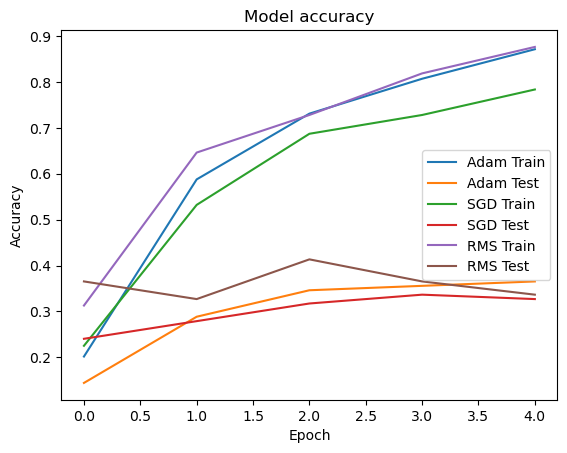

In [ ]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.plot(accuracies_sgd, label = "SGD Train")
plt.plot(val_accuracies_sgd, label = "SGD Test")

plt.plot(accuracies_RMS, label = "RMS Train")
plt.plot(val_accuracies_RMS, label = "RMS Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

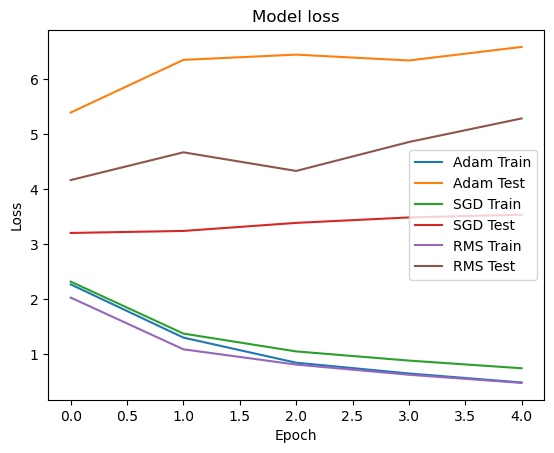

In [ ]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.plot(losses_sgd, label = "SGD Train")
plt.plot(val_losses_sgd, label = "SGD Test")

plt.plot(losses_RMS, label = "RMS Train")
plt.plot(val_losses_RMS, label = "RMS Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

# Predict the output 🔮 🎩

In [49]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

281

In [56]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

In [57]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

## Adam

In [58]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

281/281 [==============================] - 210s 708ms/step


In [59]:
print(len(pred_adam),"\n",pred_adam)

7025 
 [[1.7564199e-03 1.7808964e-02 4.0697920e-04 ... 5.6470635e-05
  3.6084361e-06 3.3040803e-07]
 [2.3837372e-04 4.1878425e-02 3.3848893e-04 ... 8.4739986e-05
  9.4415452e-03 1.3517713e-07]
 [1.2244289e-03 1.7716514e-03 5.2776963e-01 ... 1.3598466e-04
  3.5609803e-01 5.5674104e-06]
 ...
 [2.9414572e-02 8.4740501e-03 4.1449652e-03 ... 3.5894118e-06
  5.7126326e-03 1.3905544e-07]
 [3.8347628e-03 2.8612399e-01 2.0748900e-01 ... 1.9649719e-03
  9.2189759e-02 8.2649858e-05]
 [6.4445402e-07 8.6042754e-02 5.3650276e-03 ... 8.0971486e-06
  1.1043889e-04 2.3566483e-07]]


In [60]:
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

In [61]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

7025 
 [4 3 2 ... 3 3 4]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [62]:
results_adam.head()

,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,John Singer Sargent,Jan Matejko


In [63]:
len(training_set_artists)

10

In [64]:
print(training_set_artists)

['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [65]:
# amb tot junt
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists
254 / 335 = 0.7582
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
254 / 7025 = 0.0362


In [ ]:
# tf_1, tf_2...
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists
233 / 335 = 0.6955
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
233 / 7025 = 0.0332


## SGD

In [ ]:
test_gen.reset()
pred_sgd = model_sgd.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_sgd),"\n",pred_sgd)

281/281 [==============================] - 194s 653ms/step
7025 
 [[1.3056113e-02 1.1215952e-03 1.2308335e-01 ... 2.9118247e-02
  1.9993153e-03 3.2333235e-04]
 [8.3143273e-03 5.3162877e-03 2.2876920e-04 ... 9.8496664e-04
  2.1759901e-02 6.2603813e-06]
 [5.1817051e-03 2.9974637e-04 7.8479207e-01 ... 9.9840071e-03
  3.4492221e-02 4.4815935e-04]
 ...
 [2.5756818e-01 2.6326893e-02 1.4131288e-03 ... 1.7528367e-04
  2.1248840e-01 2.0221066e-04]
 [2.3100700e-02 5.3529394e-01 7.8210041e-02 ... 4.8716762e-03
  7.6840594e-02 5.5850710e-04]
 [4.9988455e-03 1.4803004e-01 5.0036356e-02 ... 5.0127665e-03
  9.6205613e-03 2.4439651e-03]]


In [ ]:
predicted_class_indices_sgd = np.argmax(pred_sgd,axis=1)

In [ ]:
results_sgd = retrieve_results(predicted_class_indices_sgd, train_gens)
results_sgd.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 9
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,Ivan Shishkin,Jan Matejko


In [ ]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [ ]:
testing_new_images(results_sgd, training_set_artists)

test accuracy on new images for TRAINED artists
227 / 335 = 0.6776
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
227 / 7025 = 0.0323


## RMSprop

In [ ]:
test_gen.reset()
pred_RMS = model_RMS.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_RMS),"\n",pred_RMS)

281/281 [==============================] - 194s 655ms/step
7025 
 [[2.1443799e-02 2.7314452e-03 1.9525861e-03 ... 7.1664699e-06
  7.4858626e-04 1.2445415e-03]
 [1.7144992e-04 4.5708535e-04 4.1855793e-07 ... 1.9475513e-06
  8.5016536e-03 8.8260066e-07]
 [1.5640775e-03 3.2066507e-03 8.0450183e-01 ... 5.2702957e-04
  6.6229612e-02 1.8388973e-06]
 ...
 [6.5013796e-02 1.3065257e-03 2.0052115e-05 ... 5.2633203e-07
  1.7853242e-01 1.7775544e-07]
 [5.2264878e-03 6.4723516e-01 5.4563824e-02 ... 3.0369400e-03
  1.5838053e-02 4.9470534e-04]
 [5.6721634e-05 4.6246450e-02 6.1807758e-03 ... 6.9209425e-05
  7.8524435e-03 2.4185749e-05]]


In [ ]:
predicted_class_indices_RMS = np.argmax(pred_RMS,axis=1)

In [ ]:
results_RMS = retrieve_results(predicted_class_indices_RMS, train_gens)
results_RMS.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,John Singer Sargent,Jan Matejko


In [ ]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [ ]:
testing_new_images(results_RMS, training_set_artists)

test accuracy on new images for TRAINED artists
231 / 335 = 0.6896
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
231 / 7025 = 0.0329


# Improving our best model

with 10400 images and 5 epochs
- Adam: test accuracy on new images for TRAINED artists 209 / 335 = 0.6239
- SGD: test accuracy on new images for TRAINED artists 178 / 335 = 0.5313
- RMSProp: test accuracy on new images for TRAINED artists 189 / 335 = 0.5642

with 13000 images and 20 epochs
- Adam: test accuracy on new images for TRAINED artists 233 / 335 = 0.6955
- SGD: test accuracy on new images for TRAINED artists 227 / 335 = 0.6776
- RMSProp: test accuracy on new images for TRAINED artists 231 / 335 = 0.6896


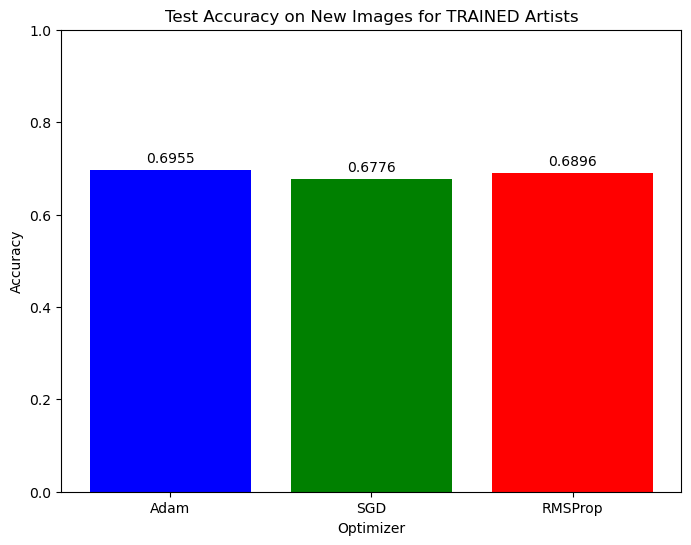

In [ ]:
import matplotlib.pyplot as plt

# Dades d'accuràcia per als diferents optimitzadors
optimizers = ['Adam', 'SGD', 'RMSProp']
accuracies = [0.6955, 0.6776, 0.6896]

# Crear el gràfic de barres
plt.figure(figsize=(8, 6))
plt.bar(optimizers, accuracies, color=['blue', 'green', 'red'])

# Afegir títol i etiquetes
plt.title('Test Accuracy on New Images for TRAINED Artists')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

# Mostrar els valors d'accuràcia sobre les barres
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.4f}', ha='center', va='bottom')

# Mostrar el gràfic
plt.ylim(0, 1)  # Ajustar el límit de l'eix Y per visualitzar millor les barres
plt.show()


## Finetuning
We finetune Adam

### Freezing all the model

In [ ]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam.layers[0]
layer1 = model_adam.layers[1]

In [ ]:
layer0.trainable = False
layer1.trainable = False

In [ ]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [ ]:
# import wandb
# from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
# wandb.login()
# # 0927244f833ccea1b247099feaaaf54084a5c30c

# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_frozen_13000im_10art"
)

In [ ]:
# wandb
MAX_EPOCHS = 20 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 #

histories_adam_frozen = model_adam.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 8/20
8/8 [==================

In [ ]:
run.finish()

batch/accuracy,▄▃▅▄▅▅▄▆▄▄▄▅▆▃▁▄▄█▁▇
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▆▅█▃▂▄▅▁▂▇▄▃▃▂█▁▆▃█▃
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁█▅▅█▅▅█▅█▅█▅▅▅▅█▅▅█
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,██▁▅▁█▅▅▅██▅█▅▁▁▅▁▁▅
batch/accuracy,0.17308


In [ ]:
# manual
histories_adam_frozen = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_frozen.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 19s 2s/step - loss: 3.1271 - accuracy: 0.0497 - val_loss: 2.4236 - val_accuracy: 0.0865
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 3.1126 - accuracy: 0.0585 - val_loss: 2.4460 - val_accuracy: 0.0865
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 14s 2s/step - loss: 3.1243 - accuracy: 0.0556 - val_loss: 2.5057 - val_accuracy: 0.0962
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 16s 2s/step - loss: 3.1022 - accuracy: 0.0497 - val_loss: 2.5226 - val_accuracy: 0.0769
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 3.1418 - accuracy: 0.0522 - val_loss: 2.4666 - val_accuracy: 0.0865


In [ ]:
accuracies_adam_frozen = []
val_accuracies_adam_frozen = []
losses_adam_frozen = []
val_losses_adam_frozen = []
for hist in histories_adam_frozen:
    if hist:
        accuracies_adam_frozen += hist.history['accuracy']
        val_accuracies_adam_frozen += hist.history['val_accuracy']
        losses_adam_frozen += hist.history['loss']
        val_losses_adam_frozen += hist.history['val_loss']

### Unfreezing layer1

In [ ]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam_unfrozen1 = Sequential()

model_adam_unfrozen1.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam_unfrozen1.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam_unfrozen1.layers[0]
layer1 = model_adam_unfrozen1.layers[1]

In [ ]:
layer0.trainable = False
layer1.trainable = True

In [ ]:
model_adam_unfrozen1.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [ ]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_unfrozen1_13000im_10art"
)

In [ ]:
# wandb
histories_adam_unfrozen1 = model_adam_unfrozen1.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.9138 - accuracy: 0.1447 - val_loss: 4.8698 - val_accuracy: 0.1908
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 1.5696 - accuracy: 0.4594 - val_loss: 5.6719 - val_accuracy: 0.2901
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.9483 - accuracy: 0.6980 - val_loss: 5.8893 - val_accuracy: 0.3206
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.6642 - accuracy: 0.7995 - val_loss: 6.1617 - val_accuracy: 0.3359
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.4971 - accuracy: 0.8604 - val_loss: 6.1832 - val_accuracy: 0.3359
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.3980 - accuracy: 0.9061 - val_loss: 6.1984 - val_accuracy: 0.3359
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.3204 - accuracy: 0.9391 - val_loss: 6.2609 - val_accuracy: 0.3359
Epoch 8/20
8/8 [==================

In [ ]:
run.finish()

batch/accuracy,▁▃▆▆▆▇▇█████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▆▇▇██████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▆▆▆▆▇▆▇▇▇█▇██▇█
epoch/val_loss,▁▅▆██████████▇▇█████
batch/accuracy,1.0


In [ ]:
# manual
histories_adam_unfrozen1 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_unfrozen1.append(
            model_adam_unfrozen1.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 49s 2s/step - loss: 1.6539 - accuracy: 0.4883 - val_loss: 111.8660 - val_accuracy: 0.1154
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.9621 - accuracy: 0.7456 - val_loss: 1932.8289 - val_accuracy: 0.1250
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.6401 - accuracy: 0.8538 - val_loss: 2012.3904 - val_accuracy: 0.0385
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7885 - accuracy: 0.7982 - val_loss: 16352.1006 - val_accuracy: 0.1346
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.4680 - accuracy: 0.8684 - val_loss: 61595.7578 - val_accuracy: 0.1731


In [ ]:
accuracies_adam_unfrozen1  = []
val_accuracies_adam_unfrozen1  = []
losses_adam_unfrozen1 = []
val_losses_adam_unfrozen1 = []
for hist in histories_adam_unfrozen1:
    if hist:
        accuracies_adam_unfrozen1 += hist.history['accuracy']
        val_accuracies_adam_unfrozen1 += hist.history['val_accuracy']
        losses_adam_unfrozen1 += hist.history['loss']
        val_losses_adam_unfrozen1 += hist.history['val_loss']

### Unfreezing layer1 and layer0

In [ ]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam_unfrozen2 = Sequential()

model_adam_unfrozen2.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam_unfrozen2.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam_unfrozen2.layers[0]
layer1 = model_adam_unfrozen2.layers[1]

In [ ]:
layer0.trainable = True
layer1.trainable = True

In [ ]:
model_adam_unfrozen2.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [ ]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_unfrozen2_13000im_10art"
)

In [ ]:
# wandb
histories_adam_unfrozen2 = model_adam_unfrozen2.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)

Epoch 1/20
8/8 [==============================] - 54s 2s/step - loss: 1.8995 - accuracy: 0.4695 - val_loss: 81.8262 - val_accuracy: 0.1527
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 0.9317 - accuracy: 0.7360 - val_loss: 7927.9980 - val_accuracy: 0.0153
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.7303 - accuracy: 0.8071 - val_loss: 12890.9775 - val_accuracy: 0.1603
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.5546 - accuracy: 0.8477 - val_loss: 19917.9297 - val_accuracy: 0.0229
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.2987 - accuracy: 0.9239 - val_loss: 7613.6284 - val_accuracy: 0.0229
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.1434 - accuracy: 0.9594 - val_loss: 3530.8250 - val_accuracy: 0.0229
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.0635 - accuracy: 0.9848 - val_loss: 939.0467 - val_accuracy: 0.0229
Epoch 8/20
8/8

In [ ]:
run.finish()

batch/accuracy,▁▆▆▇▇███████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▆▇██████▇████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▆▁▇▁▁▁▁▂▁▁▃▃▄▃▄▆▅▆█▆
epoch/val_loss,▁▄▆█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.98077


In [ ]:
# manual
histories_adam_unfrozen2 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_unfrozen2.append(
            model_adam_unfrozen2.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 47s 2s/step - loss: 1.6962 - accuracy: 0.4942 - val_loss: 1394.5631 - val_accuracy: 0.0577
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8346 - accuracy: 0.7339 - val_loss: 492.2099 - val_accuracy: 0.0288
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7245 - accuracy: 0.8158 - val_loss: 609.2695 - val_accuracy: 0.1058
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8375 - accuracy: 0.7778 - val_loss: 8467.7725 - val_accuracy: 0.0673
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.5357 - accuracy: 0.8567 - val_loss: 3787.8933 - val_accuracy: 0.0096


In [ ]:
accuracies_adam_unfrozen2  = []
val_accuracies_adam_unfrozen2  = []
losses_adam_unfrozen2 = []
val_losses_adam_unfrozen2 = []
for hist in histories_adam_unfrozen2:
    if hist:
        accuracies_adam_unfrozen2 += hist.history['accuracy']
        val_accuracies_adam_unfrozen2 += hist.history['val_accuracy']
        losses_adam_unfrozen2 += hist.history['loss']
        val_losses_adam_unfrozen2 += hist.history['val_loss']


### Comparision finetunings

#### Accuracies

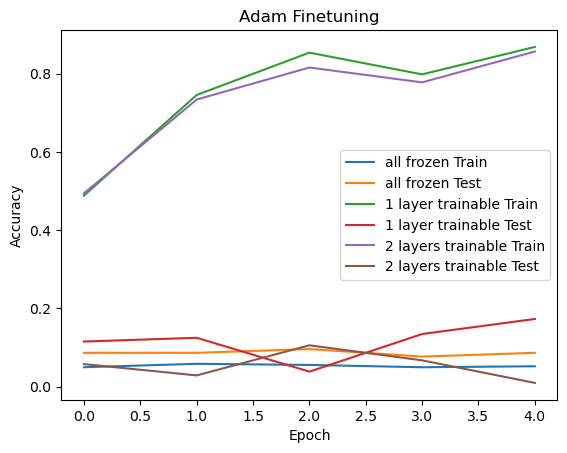

In [ ]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam_frozen, label = "all frozen Train")
plt.plot(val_accuracies_adam_frozen, label = "all frozen Test")

plt.plot(accuracies_adam_unfrozen1, label = "1 layer trainable Train")
plt.plot(val_accuracies_adam_unfrozen1, label = "1 layer trainable Test")

plt.plot(accuracies_adam_unfrozen2, label = "2 layers trainable Train")
plt.plot(val_accuracies_adam_unfrozen2, label = "2 layers trainable Test")

plt.title('Adam Finetuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_finetuning_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

#### Losses

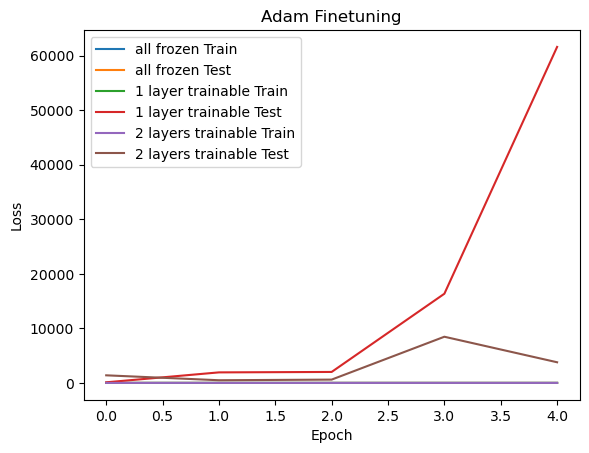

In [ ]:
# Plot training & validation accuracy values
plt.plot(losses_adam_frozen, label = "all frozen Train")
plt.plot(val_losses_adam_frozen, label = "all frozen Test")

plt.plot(losses_adam_unfrozen1, label = "1 layer trainable Train")
plt.plot(val_losses_adam_unfrozen1, label = "1 layer trainable Test")

plt.plot(losses_adam_unfrozen2, label = "2 layers trainable Train")
plt.plot(val_losses_adam_unfrozen2, label = "2 layers trainable Test")

plt.title('Adam Finetuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_finetuning_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

## Predictions

In [ ]:
model = model_adam_unfrozen1

In [ ]:
test_gen.reset()
pred_adam = model.predict(test_gen)
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

281/281 [==============================] - 193s 652ms/step


In [ ]:
results_adam_unfrozen1 = retrieve_results(predicted_class_indices_adam, train_gens)

7025 
 [4 3 8 ... 3 1 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [ ]:
testing_new_images(results_adam_unfrozen1, training_set_artists)

test accuracy on new images for TRAINED artists
229 / 335 = 0.6836
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
229 / 7025 = 0.0326


# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

## Mosaics

In [66]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


### Predictions

In [67]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/compositions/predictions_2600_images/composition_{}.png'.format(predicted_artist))


KeyboardInterrupt: 

### Real values

In [ ]:
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

In [ ]:
grouped_data

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
filtered_data = results_adam[results_adam['Real Values'].isin(training_set_artists)]
grouped_data = filtered_data.groupby('Real Values')# tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/real_values_13000_images/composition_{}.png'.format(predicted_artist))


Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 99, in run
    sreq = self._sock_client.read_server_request()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 274, in read_server_request
    data = self._read_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 248, in _read_packet_bytes
    rec = self._extract_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 230, in _extract_packet_bytes
    assert magic == ord("W")
AssertionError
Bad pipe message: %s [b'\xd2\xe9\xa0\xf1I\xb7}r\xe0\x7f\xc0\x83\xc1\xa2A\xa6\xeb\x8e P\xa0f\xb6\xd3\x198\x0e\x8e\xcag\xf0', b'\x19a\x03u\xba\xbe\xfb\x